# ERNIE SFT Best Practices

# 1 Introduction to SFT
### 1.1 What is SFT?
SFT (Supervised Fine-Tuning) is a key technique for customizing pre-trained large models. By continuing to train the model with a **small amount of high-quality labeled data**, it's possible to enhance its performance in specific domains at a low cost and with high speed.

### 1.2 When to Use SFT
- ✅ Applicable Scenarios:
  - Task Adaptation: Strengthening the model's understanding of specific tasks (e.g., text classification, information extraction).
  - Reinforcing existing abilities or knowledge the model already possesses.
  - Teaching the model to handle more complex, composite tasks (provided it already has the ability to complete the relevant sub-tasks).

- ❌ Inapplicable Scenarios:
  - Injecting new internal knowledge into the model.
  - Forcing the model to learn abilities it doesn't have.
  - Completely correcting inherent biases from the pre-trained model.
  - Tackling scenarios that require complex reasoning or long-term memory (which may require techniques like reinforcement learning).


### 1.3 General Steps for SFT
1. Prepare evaluation data and metrics, test the base model's capabilities, and analyze its shortcomings and issues.
2. Conduct comprehensive prompt engineering.
3. Determine if SFT is the right approach; prepare the training data.
4. Training. Design training parameters based on the task's characteristics and the data. Key hyperparameters to focus on include:
    - Batch size
    - Number of training epochs / Maximum training steps
    - Learning rate scheduler type / Initial learning rate
    - Warmup steps
5. Performance Evaluation. Using the same evaluation data and metrics, assess the performance of the fine-tuned model. If it falls short of expectations, consider further optimizing the training data or tuning the hyperparameters.

# 2. Introduction to the Best Practice Task

### 2.1 Task Description
For this best practice example, we've chosen a function-calling task. Given a set of tool functions and a multi-turn dialogue, the model's objective is to select the most appropriate tool to complete the task based on the dialogue context. For simplicity, the model only needs to output the name of the tool function.

### 2.2 Glossary
To make things clearer, we'll define the following terms:
- **session**: A multi-turn dialogue, consisting of multiple question-and-answer pairs.
- **round**: A single dialogue turn, including one question and one answer.
- **history**: Session data formatted according to the OpenAI API standard.

### 2.3 Data Source
We use the popular open-source `glaive_toolcall` dataset ([link](https://huggingface.co/datasets/llamafactory/glaive_toolcall_en)). This dataset contains 1,000 entries each in Chinese and English, formatted in the ShareGPT style with the following fields:
- `conversations`: The dialogue context, in `[{"from": "", "value": ""}]` format. The `from` field includes:
  - `human`: User input.
  - `gpt`: Model output (here, `gpt` is used generically to refer to a large model conversational assistant).
  - `function_call`: The specific tool being called and its parameters.
  - `observation`: The result of the tool call.
- `tools`: The list of available tools and their descriptions.

### 2.4 Evaluation Metrics
This is a multi-class classification task. We will evaluate the model's performance using accuracy, macro-average, micro-average, and weighted-average metrics.

### 2.5 Experiment Environment
This tutorial uses the following environment:
- 1 x 80GB A800 GPU
- CUDA Version: 12.3
- CUDA Driver: 525.125.06
- nvcc: 12.3
- gcc: 12.2
- Python Version: 3.10.12

### 2.6 Dependencies
- **ERNIEKit**: The ERNIE large model toolchain, which provides an end-to-end workflow for training, compressing, and deploying the ERNIE 4.5 series models. It is based on PaddlePaddle v3.1 and supports training on several mainstream domestic chips.
- **ERNIEKit WebUI**: A graphical interface that supports training, interactive dialogue, performance evaluation, model exporting, and other features. [Docs](docs/cli_webui_usage.md)
- **[Optional] visualdl**: A tool for visualizing information like loss curves, which is already included in ERNIEKit.
- **ERNIEKit inference scripts**.
- **The Python dependencies** used in this tutorial.


In [1]:
# The Python dependencies
import json
import random
from collections import defaultdict
from string import Template

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 2025

# 3. Data Preprocessing

First, let's examine the `glaive_toolcall` dataset. We can see that there are cases where multiple function calls occur within the same session. For such data, we will split them into multiple sessions, using each function call as a boundary.

Next, we will process the `glaive_toolcall` dataset to align with the data formats required by ERNIEKit for training and inference.
  - **Training data**: A `jsonl` file, with each line as `{"system": "", "src": [], "tgt": [], "label": []}`
    - `system` (str, optional): A prompt that sets system information, such as persona, task instructions, style definitions, etc.
    - `src` (list(str)): The user's multi-turn dialogue content, arranged by turn and corresponding to `tgt`.
    - `tgt` (list(str)): The system's multi-turn responses, arranged by turn and corresponding to `src`.
    - `label` (list(int), optional): Marks whether the current dialogue turn should be used for training. `1` indicates it's included in training (for loss calculation), while `0` means it's excluded. If this field is omitted, all turns are used for training.
  - **Inference data**: A `jsonl` file, with each line as `[{"role": "", "content": ""}]`. The `role` field can be `system`, `user`, or `assistant`.

Considering the formats above, we will reformat the `glaive_toolcall` dataset into the following structure: a `jsonl` file where each line is `[{"role": "", "content": ""}]`. The `role` can be `system`, `user`, or `assistant`. The `user` and `assistant` roles appear in pairs according to the dialogue sequence, and the final `assistant` message records the name of the tool called.

### 3.1 Prepare the Raw Data
First, let's download the open-source dataset. Save at `cookbook/data/glaive_toolcall_en_1k.json`。

![sft_download_dataset](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_download_dataset_en.png)

To facilitate processing, we will convert the ShareGPT format to the OpenAI API format and log the tool call information. We have defined several functions for data preprocessing.

In [2]:
def parse_function(tools, func_name_with_desc: dict):
    """Parses the tool list to get tool names and descriptions.

    Args:
        tools: The list of tools.
        func_name_with_desc: A dictionary to store the mapping of tool names to their descriptions.

    Returns:
        func_name_with_desc: The updated dictionary mapping tool names to descriptions.
    """
    for tool in tools:
        tool_name = tool.get("name", "")
        tool_desc = tool.get("description", "")
        func_name_with_desc[tool_name] = tool_desc
    return func_name_with_desc


def is_valid_history(history):
    """Checks if the conversation history is valid: user and assistant roles must appear in pairs, and the last turn must be from the assistant.

    Args:
        history: Multi-turn dialogue data in OpenAI API format.

    Returns:
        bool: True if the history is valid, False otherwise.
    """
    # Remove the system prompt for easier calculation.
    history = [h for h in history if h.get("role", "") != "system"]
    if len(history) < 2 or len(history) % 2 != 0:
        return False
    for i in range(1, len(history), 2):
        if history[i]["role"] != "assistant" or history[i - 1]["role"] != "user":
            return False
    else:
        return True


def conversations_to_history(conversations):
    """Converts conversation data from ShareGPT format to OpenAI API format.

    Args:
        conversations: Conversation data in ShareGPT format.

    Yields:
        history: Multi-turn dialogue data in OpenAI API format.
    """
    NO_FUNCTION_CALL_MARK = "<|NO_FUNCTION_CALL|>"
    had_function_call = False
    history = []
    for conversation in conversations:
        if conversation.get("from", "") == "human":
            history.append({"role": "user", "content": conversation.get("value", "")})
        elif conversation.get("from", "") == "function_call":
            history.append({"role": "assistant", "content": json.loads(conversation.get("value", "")).get("name", "")})
            if is_valid_history(history):
                yield history
                had_function_call = True
                history.pop()
                # If there are more turns in the dialogue, the 'assistant' field will use the 'gpt' content
                # from the original data (not the 'function_call').
                # Therefore, we remove the current 'assistant' to prepare for the next turn.

        elif conversation.get("from", "") == "gpt":
            if had_function_call:
                history.append({"role": "assistant", "content": conversation.get("value", "")})
                had_function_call = False
            else:
                history.append({"role": "assistant", "content": NO_FUNCTION_CALL_MARK})
                if is_valid_history(history):
                    yield history
                    history.pop()
                    history.append({"role": "assistant", "content": conversation.get("value", "")})
        else:
            pass


def history_to_train(history, system_prompt: str = ""):
    """Converts multi-turn dialogue from OpenAI API format to ERNIE training data format.

    Args:
        history: Multi-turn dialogue data in OpenAI API format.

    Returns:
        data: Training data in ERNIE format.
    """
    data = {"system": system_prompt, "src": [], "tgt": [], "label": []}
    if not is_valid_history(history):
        return {}

    for h in history:
        role = h.get("role", "")
        content = h.get("content", "")
        if role == "user":
            data["src"].append(content)
        elif role == "assistant":
            data["tgt"].append(content)
        data["label"] = [0] * (len(data["tgt"]) - 1) + [1]
    return data


def history_to_test(history, system_prompt: str = ""):
    """Converts multi-turn dialogue from OpenAI API format to ERNIE inference data format.

    Args:
        history: Multi-turn dialogue data in OpenAI API format.

    Returns:
        data: Inference data in ERNIE format.
    """
    return [{"role": "system", "content": system_prompt}] + history

We call the functions defined above to process the data.

In [3]:
raw_data_path = "../data/glaive_toolcall_en_1k.json"
history_path = raw_data_path.replace('.json', '_history.jsonl')
func_name_with_desc = {}

with open(raw_data_path, "r") as fin:
    with open(history_path, "w") as fout:
        data_list = json.load(fin)
        for data in data_list:
            for history in conversations_to_history(data.get("conversations", [])):
                fout.write(json.dumps(history, ensure_ascii=False) + "\n")
            # Record the function call information as well
            parse_function(json.loads(data.get("tools", [])), func_name_with_desc)

func_name_with_desc["<|NO_FUNCTION_CALL|>"] = "No function call is needed"

### 3.2 Analyze the Raw Data
Let's observe how each tool is used, and then construct the training and test sets accordingly.

In [4]:
func_cnt = {}
with open(history_path, 'r') as fin:
    for line in fin:
        data = json.loads(line)
        func_name = data[-1].get("content", "")
        func_cnt[func_name] = func_cnt.get(func_name, 0) + 1

func_cnt = dict(sorted(func_cnt.items(), key=lambda x: x[1], reverse=True))

Let's perform a simple visual analysis of the tool call distribution.

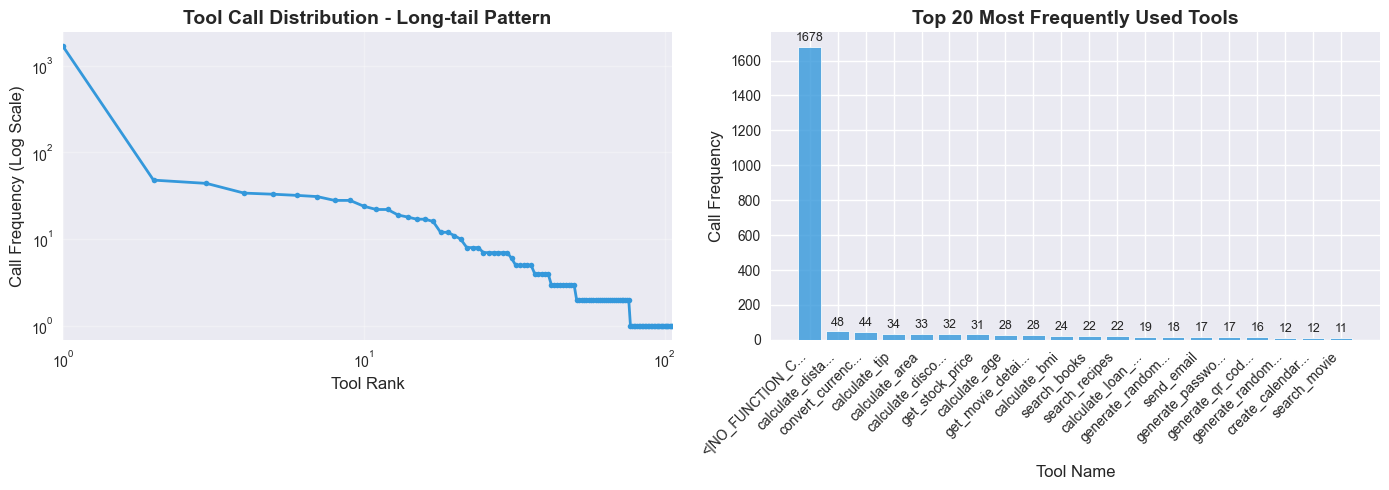

In [5]:
# Set style and figure
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Prepare data
tools = list(func_cnt.keys())
counts = list(func_cnt.values())

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Long-tail distribution (log scale)
ax1.loglog(range(1, len(counts) + 1), counts, 'o-', linewidth=2, markersize=4, color='#3498db')
ax1.set_xlabel('Tool Rank', fontsize=12)
ax1.set_ylabel('Call Frequency (Log Scale)', fontsize=12)
ax1.set_title('Tool Call Distribution - Long-tail Pattern', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, len(counts))

# Right plot: Top 20 tools bar chart
top_20_tools = tools[:20]
top_20_counts = counts[:20]

# Truncate tool names for better display
display_tools = [tool[:15] + "..." if len(tool) > 15 else tool for tool in top_20_tools]

bars = ax2.bar(range(len(top_20_tools)), top_20_counts, color='#3498db', alpha=0.8, edgecolor='white', linewidth=0.7)
ax2.set_xlabel('Tool Name', fontsize=12)
ax2.set_ylabel('Call Frequency', fontsize=12)
ax2.set_title('Top 20 Most Frequently Used Tools', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(top_20_tools)))
ax2.set_xticklabels(display_tools, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(top_20_counts)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
# Print statistical information
total_tools = len(func_cnt)
total_calls = sum(func_cnt.values())
print(f"Total number of tools: {total_tools}")
print(f"Total number of calls: {total_calls}")
print(f"Average calls per tool: {total_calls/total_tools:.2f}")
print(f"Most frequently called tool: {tools[0]} ({counts[0]} calls)")
print(f"Number of tools called only once: {sum(1 for c in counts if c == 1)}")
print(f"Number of tools called 5 or more times: {sum(1 for c in counts if c >= 5)}")

Total number of tools: 106
Total number of calls: 2382
Average calls per tool: 22.47
Most frequently called tool: <|NO_FUNCTION_CALL|> (1678 calls)
Number of tools called only once: 30
Number of tools called 5 or more times: 36


Set the system prompt. After some simple experiments, we will use the system prompt that performed best in our tests.

In [7]:
system_prompt_template = Template(
    """You are an intelligent assistant that can find the most suitable tool to complete a task based on user needs. Please refer to the following list of tools to complete the task. Note:
1. Only return the tool name, do not return any other content.
2. Do not execute the task itself, only return the tool name. For example, if the user needs to convert Celsius to Fahrenheit, you only need to return the string 'convert_temperature'.
3. If you think no tool needs to be called, please return the string '<|NO_FUNCTION_CALL|>'. For example, if the user is just asking for general information, or has explicitly requested not to use a tool.
4. You can only call tools from the list; do not make up tools.

Available tools:
${tools_prompt}"""
)

In [8]:
tools_prompt = ""
for tool_name, tool_desc in func_name_with_desc.items():
    tools_prompt += f"Tool Name: {tool_name}\n"
    tools_prompt += f"Tool Description: {tool_desc}\n"
    tools_prompt += "\n"
tools_prompt = tools_prompt.strip()

### 3.3 Evaluate the Base Model's Capabilities
Define the evaluation metrics.

In [9]:
def calculate_multiclass_metrics(data):
    """
    Calculates the accuracy, precision, recall, and F1 score for a multi-class classification task.

    Args:
        data: A list where each element is a dictionary in the format {"ground_truth": "", "prediction": ""}.

    Returns:
        A dictionary containing overall metrics and per-class metrics.
    """
    if not data:
        return {}

    # Extract all ground truth and predicted labels
    y_true = [item["ground_truth"] for item in data]
    y_pred = [item["prediction"] for item in data]

    # Only consider classes present in the ground truth labels
    true_classes = set(y_true)

    # Calculate overall accuracy
    correct = sum(1 for gt, pred in zip(y_true, y_pred) if gt == pred)
    total = len(data)
    accuracy = correct / total if total > 0 else 0

    # Calculate metrics for each true class
    class_metrics = {}
    precision_list = []
    recall_list = []
    f1_list = []
    support_list = []

    for cls in true_classes:
        # Calculate TP, FP, FN
        tp = sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred == cls)
        fp = sum(1 for gt, pred in zip(y_true, y_pred) if gt != cls and pred == cls)
        fn = sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred != cls)

        # Calculate precision, recall, F1 (maintaining original precision)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = sum(1 for gt in y_true if gt == cls)

        class_metrics[cls] = {
            "precision": round(precision * 100, 3),
            "recall": round(recall * 100, 3),
            "f1_score": round(f1 * 100, 3),
            "support": support,
        }

        # Collect raw values for calculating averages
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        support_list.append(support)

    # Calculate macro average - using raw precision values
    macro_precision = sum(precision_list) / len(precision_list) if precision_list else 0
    macro_recall = sum(recall_list) / len(recall_list) if recall_list else 0
    macro_f1 = sum(f1_list) / len(f1_list) if f1_list else 0

    # Calculate micro average
    total_tp = sum(sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred == cls) for cls in true_classes)
    total_fp = sum(sum(1 for gt, pred in zip(y_true, y_pred) if gt != cls and pred == cls) for cls in true_classes)
    total_fn = sum(sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred != cls) for cls in true_classes)

    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    micro_f1 = (
        2 * micro_precision * micro_recall / (micro_precision + micro_recall)
        if (micro_precision + micro_recall) > 0
        else 0
    )

    # Calculate weighted average - using raw precision values
    total_support = sum(support_list)
    weighted_precision = (
        sum(p * s for p, s in zip(precision_list, support_list)) / total_support if total_support > 0 else 0
    )
    weighted_recall = sum(r * s for r, s in zip(recall_list, support_list)) / total_support if total_support > 0 else 0
    weighted_f1 = sum(f * s for f, s in zip(f1_list, support_list)) / total_support if total_support > 0 else 0

    return {
        "accuracy": f"{round(accuracy * 100, 3)}%",
        "macro_avg": {
            "precision": f"{round(macro_precision * 100, 3)}%",
            "recall": f"{round(macro_recall * 100, 3)}%",
            "f1_score": f"{round(macro_f1 * 100, 3)}%",
        },
        "micro_avg": {
            "precision": f"{round(micro_precision * 100, 3)}%",
            "recall": f"{round(micro_recall * 100, 3)}%",
            "f1_score": f"{round(micro_f1 * 100, 3)}%",
        },
        "weighted_avg": {
            "precision": f"{round(weighted_precision * 100, 3)}%",
            "recall": f"{round(weighted_recall * 100, 3)}%",
            "f1_score": f"{round(weighted_f1 * 100, 3)}%",
        },
        "per_class": class_metrics,
        "total_samples": total,
        "correct_predictions": correct,
    }

Construct the test set. Based on the analysis above, the distribution of functions in the original dataset is highly imbalanced. We will focus on functions that have at least 5 samples, and randomly select 2 instances for each.

In [10]:
with open(history_path, "r") as fin:
    all_histories = [json.loads(line) for line in fin]

# Find frequently called tools
frequent_funcs = {func_name: count for func_name, count in func_cnt.items() if count >= 5}

# Find the dialogue indices corresponding to the frequently called tools
history_idx_called_frequent_func = defaultdict(list)
for idx, history in enumerate(all_histories):
    func_name = history[-1].get("content", "")
    if func_name in frequent_funcs:
        history_idx_called_frequent_func[func_name].append(idx)

random.seed(RANDOM_SEED)
test_indices = set()
for tool, history_indices in history_idx_called_frequent_func.items():
    selected = random.sample(history_indices, 2)
    test_indices.update(selected)

# Save the test set: one version without ground truth for inference, and another with ground truth for evaluation.
testset_no_gt_path = "../data/sft_testset_no_gt.jsonl"
testset_has_gt_path = "../data/sft_testset_has_gt.jsonl"
with open(testset_no_gt_path, "w") as no_gt, open(testset_has_gt_path, "w") as has_gt:
    for idx in test_indices:
        testset_history = all_histories[idx]
        ground_truth = testset_history.pop().get("content", "")
        no_gt.write(
            json.dumps(
                history_to_test(
                    history=testset_history, system_prompt=system_prompt_template.substitute(tools_prompt=tools_prompt)
                ),
                ensure_ascii=False,
            )
            + "\n"
        )
        has_gt.write(json.dumps({"history": testset_history, "ground_truth": ground_truth}, ensure_ascii=False) + "\n")

Run inference on the test set using the base model. The WebUI does not currently support inference on test sets, so we will use an inference script from the ERNIEKit codebase.
- **Script**: `tools/inference/scripts/infer.sh`
- **Set the main hyperparameters**:
  - `top_p=0.7`
  - `temperature=0.7`
  - `max_seq_len=128000` (ERNIE-4.5-0.3B supports a dynamic 128K context length)
  - `max_dec_len=64` (our task does not require a long output)
  - `weight_quantize_algo` This line can be deleted if quantization was not used during training.

> Inference process omitted.

Calculate the evaluation metrics.

In [11]:
# Get inference results
prediction_data_path = "../data/infer/sft_03b_exp0.jsonl"

# To handle potentially out-of-order results, we'll reorganize and map the inference results to the input information.
history2gt = {}
with open(testset_has_gt_path, "r") as fin:
    for line in fin:
        data_eval = json.loads(line.strip())
        history2gt[json.dumps(data_eval["history"], ensure_ascii=False)] = data_eval["ground_truth"]

history2pred = {}
with open(prediction_data_path, "r") as fin:
    for line in fin:
        data_pred = json.loads(line.strip())
        history2pred[json.dumps(data_pred[1:-1], ensure_ascii=False)] = data_pred[-1]["content"]

pred2gt = []
for history, pred in history2pred.items():
    pred2gt.append({"ground_truth": history2gt[history], "prediction": pred})

# Calculate multi-class metrics
results = calculate_multiclass_metrics(pred2gt)
print("Evaluation Results:")
print(f"Accuracy: {results['accuracy']}")
print(
    f"Macro Avg - Precision: {results['macro_avg']['precision']}, Recall: {results['macro_avg']['recall']}, F1: {results['macro_avg']['f1_score']}"
)
print(
    f"Micro Avg - Precision: {results['micro_avg']['precision']}, Recall: {results['micro_avg']['recall']}, F1: {results['micro_avg']['f1_score']}"
)
print(
    f"Weighted Avg - Precision: {results['weighted_avg']['precision']}, Recall: {results['weighted_avg']['recall']}, F1: {results['weighted_avg']['f1_score']}"
)


# Convert per-class results to a DataFrame for easier analysis
per_class_data = []
for class_name, metrics in results['per_class'].items():
    per_class_data.append(
        {
            'Class': class_name,
            'Precision(%)': str(metrics['precision']).rstrip('%'),
            'Recall(%)': str(metrics['recall']).rstrip('%'),
            'F1 Score(%)': str(metrics['f1_score']).rstrip('%'),
            'Support': metrics['support'],
        }
    )

df_per_class = pd.DataFrame(per_class_data)
print("\nDetailed Metrics Per Class:")
df_per_class

Evaluation Results:
Accuracy: 2.532%
Macro Avg - Precision: 2.75%, Recall: 2.5%, F1: 2.083%
Micro Avg - Precision: 5.714%, Recall: 2.532%, F1: 3.509%
Weighted Avg - Precision: 2.785%, Recall: 2.532%, F1: 2.11%

Detailed Metrics Per Class:


,Class,Precision(%),Recall(%),F1 Score(%),Support
0,calculate_mortgage,0,0.0,0,2
1,calculate_age,0,0.0,0,2
2,generate_password,0,0.0,0,2
3,calculate_area,0,0.0,0,2
4,create_todo,0,0.0,0,2
5,calculate_average,0,0.0,0,2
6,get_movie_details,0,0.0,0,2
7,calculate_tax,0,0.0,0,2
8,calculate_discount,0,0.0,0,2
9,create_calendar_event,0,0.0,0,2


### 3.4 Making Training Set
Evidently, the current model is completely unable to select the appropriate tool functions, making SFT a necessary step. Therefore, we will construct the training and validation sets. Of the data not included in the test set, 10% will be allocated for validation, and the remainder will be used for training.

In [12]:
trainset_path = "../data/sft_trainset.jsonl"
validset_path = "../data/sft_validset.jsonl"

# Split the validation set from the non-test data
remaining_indices = [idx for idx in range(len(all_histories)) if idx not in test_indices]
random.shuffle(remaining_indices)
valid_size = int(len(remaining_indices) * 0.1)
valid_indices = set(remaining_indices[:valid_size])
train_indices = set(remaining_indices[valid_size:])

# Save the training set
with open(trainset_path, "w") as fout:
    for idx in train_indices:
        history = all_histories[idx]
        train_data = history_to_train(
            history=history, system_prompt=system_prompt_template.substitute(tools_prompt=tools_prompt)
        )
        fout.write(json.dumps(train_data, ensure_ascii=False) + "\n")

# Save the validation set
with open(validset_path, "w") as fout:
    for idx in valid_indices:
        history = all_histories[idx]
        valid_data = history_to_train(
            history=history, system_prompt=system_prompt_template.substitute(tools_prompt=tools_prompt)
        )
        fout.write(json.dumps(valid_data, ensure_ascii=False) + "\n")

# 4. Training
### 4.1 Select the Base Model
For ease of demonstration and considering the task's complexity, we'll choose the smaller ERNIE-4.5-0.3B model.

### 4.2 Design Training Parameters
Designing training parameters is largely based on experience. ERNIEKit allows users to set a few key parameters and automatically recommends the rest. Typically, the key parameters you need to set are:
- `num_train_epochs`
- `gradient_accumulation_steps`
- `max_seq_len=8192`

Calculate recommended parameters (see `examples/post-training/sft/README.md` for details):
```bash
python examples/post-training/sft/estimate_training.py \
    --train_dataset_path examples/data/sft-train.jsonl \
    --train_dataset_type erniekit \
    --train_dataset_prob 1.0 \
    --model_name_or_path baidu/paddle_internal/ERNIE-4.5-0.3B \
    --out_file estimate_training.json \
    --num_train_epochs 1 \
    --max_seq_len 8192 \
    --num_of_gpus 1 \
    --per_device_train_batch_size 1 \
    --tensor_parallel_degree 1 \
    --pipeline_parallel_degree 1 \
    --sharding_parallel_degree 1 \
    --seed 23 \
    --num_samples_each_epoch 6000000
```

### 4.3 Train with the WebUI
1. Launch the WebUI from the ERNIEKit project's root directory: `erniekit webui`
2. Configure the model path and export directory.

![sft_set_path](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_set_path_en.png)

3. Set up full-parameter/LoRA fine-tuning, numerical precision, etc.

![sft_lora_set](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_set_lora_en.png)

4. Set the fine-tuning mode (SFT/DPO) and configure training parameters.

![sft_train_params](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_train_params_en.png)

5. Configure the training and validation sets.

<div style="display: flex; justify-content: space-around;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_trainset_en.png" alt="sft_trainset" style="width: 49%;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_validset_en.png" alt="sft_validset" style="width: 49%;">
</div>

### 4.4 View Training Logs and Loss Curves
The training log path is `${your_model_dir}/paddle_dist_log/workerlog.0`. You can also run the following command to view the loss curve:
```bash
visualdl --logdir ${your_model_dir}/vdl_log --host 0.0.0.0
```
Here is an example of a loss curve viewed in VisualDL:

![sft_visualdl_loss](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_visualdl_loss.png)

### 4.5 Merge Model Weights (Only for LoRA Fine-Tuning)
You can easily merge model weights in the WebUI's "Evaluation" mode.

![sft_merge_lora](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_merge_lora_en.png)

# 5. Performance Evaluation

### 5.1 Calculate Evaluation Metrics
We have already defined the evaluation criteria and demonstrated how to calculate the metrics. Here, we will not repeat that but will instead present the training configurations and evaluation metrics from several experiments for your reference. We also tested the performance of the ERNIE-4.5-21B-A3B model with the same configuration.

- ERNIE-4.5-0.3B  

| Experiment No. | Manually Configured Parameters | Corresponding Recommended Parameters | Metrics |
| --- | --- | --- | --- |
| 0 | Base model without SFT | - | ↑Accuracy: 2.532% <br> ↑Macro Avg - Precision: 2.75%, Recall: 2.5%, F1: 2.083% <br> ↑Micro Avg - Precision: 5.714%, Recall: 2.532%, F1: 3.509% <br> ↑Weighted Avg - Precision: 2.785%, Recall: 2.532%, F1: 2.11% |
| 1 | num_train_epochs=1 <br> gradient_accumulation_steps=1 <br> max_seq_len=8192 <br> num_of_gpus=4 <br> tensor_parallel_degree=4 | max_steps=1070 <br> global_batch_size=1 <br> warmup_steps=107 | ↑Accuracy: 87.342% <br> ↑Macro Avg - Precision: 89.583%, Recall: 87.5%, F1: 87.0% <br> ↑Micro Avg - Precision: 90.789%, Recall: 87.342%, F1: 89.032% <br> ↑Weighted Avg - Precision: 89.451%, Recall: 87.342%, F1: 86.835% |

- ERNIE-4.5-21B-A3B  

| Experiment No. | Manually Configured Parameters | Corresponding Recommended Parameters | Metrics |
| ---- | ---- | ---- | ---- |
| 0 | Base model without SFT | - | ↑Accuracy: 48.101%<br>↑Macro Avg - Precision: 54.583%, Recall: 48.75%, F1: 49.333%<br>↑Micro Avg - Precision: 52.055%, Recall: 48.101%, F1: 50.0%<br>↑Weighted Avg - Precision: 54.008%, Recall: 48.101%, F1: 48.692% |
| 1 | num_train_epochs=1<br>gradient_accumulation_steps=1<br>max_seq_len=8192<br>num_of_gpus=4<br>tensor_parallel_degree=4 | max_steps=1070<br>global_batch_size=1<br>warmup_steps=107 | ↑Accuracy: 89.873%<br>↑Macro Avg - Precision: 87.083%, Recall: 90.0%, F1: 87.333%<br>↑Micro Avg - Precision: 89.873%, Recall: 89.873%, F1: 89.873%<br>↑Weighted Avg - Precision: 86.92%, Recall: 89.873%, F1: 87.173% |

### 5.2 Analyze the Experimental Results
As we can see, the current model has achieved impressive metrics. However, there's still room for exploration and improvement. We have prepared a few data analysis tools to help us find clues for further optimizing the model.

In [13]:
def get_histories_by_function_name(function_name, eval_data_path, prediction_data_path):
    """
    Retrieves the corresponding dialogue histories for a given function name.

    Args:
        function_name: The name of the function to search for.
        eval_data_path: The file path for the evaluation data (with ground truth).
        prediction_data_path: The file path for the prediction data.

    Returns:
        A tuple (gt_histories, pred_histories), where each element is a list of
        histories that match the ground truth and prediction labels, respectively.
    """
    history2gt = {}
    with open(eval_data_path, "r") as fin:
        for line in fin:
            data_eval = json.loads(line.strip())
            history2gt[json.dumps(data_eval["history"], ensure_ascii=False)] = data_eval["ground_truth"]

    history2pred = {}
    with open(prediction_data_path, "r") as fin:
        for line in fin:
            data_pred = json.loads(line.strip())
            history2pred[json.dumps(data_pred[1:-1], ensure_ascii=False)] = data_pred[-1]["content"]

    # Find histories where the ground truth matches the function name
    gt_histories = []
    for history_str, gt in history2gt.items():
        if gt == function_name:
            history_data = json.loads(history_str)
            history_data.append({"ground_truth": function_name})
            gt_histories.append(history_data)

    # Find histories where the prediction matches the function name
    pred_histories = []
    for history_str, pred in history2pred.items():
        if pred == function_name:
            history_data = json.loads(history_str)
            history_data.append({"prediction": function_name})
            pred_histories.append(history_data)

    return gt_histories, pred_histories

### 5.3 Catastrophic Forgetting
We have observed that the model's performance declines after SFT on the function-calling task, exhibiting a degree of "catastrophic forgetting." For example:

> Input: `[{"role": "user", "content": "Please remember, your name is Pipilu"}, {"role": "assistant", "content": "Okay, I am Pipilu"}, {"role": "user", "content": "Who are you?"}]`

> ERNIE-4.5-0.3B Base Model Output: I am Pipilu! How can I help you?
> SFT Model Output: `get_definition`

This is a common phenomenon in large language model SFT. The data for this task is relatively specialized, causing SFT to enhance the model's performance on this specific task while degrading its general capabilities. To maintain the model's general abilities, we can simply adopt a **data mixing strategy** to alleviate this issue. ERNIE provides several general-purpose SFT datasets that can be mixed with downstream task data (like the function-calling data here) for SFT.

# 6 FAQ

### 6.1 What should I do if I can't fine-tune the 32B model even with four 80GB A800 GPUs?

You can configure the "Distributed Parameters" in the WebUI as follows:

![sft_21b_distributed_params_en](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_21b_distributed_params_en.png)